# Bulk RNA-seq data analysis and geneset scoring demonstration

## 0. Setting up environment and loading data

In [1]:
suppressPackageStartupMessages({
    library(DESeq2)
    library(tidyverse)
    library(ggrepel)
    library(patchwork)
    library(Matrix)
})

In [2]:
counts <- read.delim(file = "data/ID_count_matrix.tsv", sep = "\t", row.names = 1)
names(counts) <- gsub(" ", "", names(counts))

In [3]:
metadata <- read.delim(file = "data/metadata.txt", sep = "\t", row.names = 1)
names(metadata) <- gsub(" ", "", names(metadata))

# 1. Analysis using both medium (treatment vs control) and timepoint as variables

The following model is fit using a subset of the data to address the question whether the treatment with C8mod induces a change in gene expression at any time point after the reference level time point (time 0).

## 1.1. Making the model matrix full rank

In [4]:
c8neg_samples <- rownames(metadata[which(metadata$Medium %in% c("C8neg", "DMEM-C")),])
cols.to.keep <- !names(counts) %in% c8neg_samples
counts_subset <- counts[, cols.to.keep]

d28_samples <- rownames(metadata[which(metadata$Timepoint == "D28"),])
cols.to.keep <- !names(counts_subset) %in% d28_samples
counts_subset <- counts_subset[, cols.to.keep]

agarose_samples <- rownames(metadata[which(metadata$Platform == "Agarose"),])
cols.to.keep <- !names(counts_subset) %in% agarose_samples

counts_subset <- counts_subset[, cols.to.keep]

In [5]:
rows.to.keep <- which(rownames(metadata) %in% colnames(counts_subset))
metadata_subset <- metadata[rows.to.keep,]
write.table(metadata_subset, file = "data/metadata_subset.tsv", sep = "\t", quote = FALSE)

In [6]:
metadata_subset <- read.delim(file = "data/metadata_subset.tsv", header = TRUE, row.names = 1)

In [7]:
dds <- DESeqDataSetFromMatrix(countData = counts_subset,
                              colData = metadata_subset,
                              design= ~ Medium + Timepoint + Medium:Timepoint)
dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 57787 32 
metadata(1): version
assays(1): counts
rownames(57787): 5S_rRNA 7SK ... ZYXP1 ZZEF1
rowData names(0):
colnames(32): GC1001709 GC1001710 ... GC1003647 GC1003648
colData names(5): Experiment Pool Timepoint Platform Medium

In [8]:
# order chronologically
dds$Timepoint <- relevel(dds$Timepoint, "D7")
dds$Timepoint <- relevel(dds$Timepoint, "5h")

levels(dds$Timepoint)

[1] "5h"  "D7"  "D14" "D21"

In [9]:
# make sure C8 is the reference
levels(dds$Medium)

[1] "C8"    "C8mod"

## 1.2. Stabilizing variance
Many common statistical methods for exploration of multidimensional data such as PCA work best for data that genereally has the same range of variance at different ranges of the mean values. For RNA-seq counts however, the expected variance grows with the mean. Consequently, if one performs PCA directly on a matrix of counts or normalized counts the resulting plot typically depends mostly on the genes with highest counts because they show the largest absolute differences between samples.

Here, we will use the regularized-logarithm transformation or rlog.

In [10]:
rld <- rlog(dds, fitType = "local", blind = FALSE)

rlog() may take a few minutes with 30 or more samples,
vst() is a much faster transformation



In the above function calls, we specified blind = FALSE, which means that differences between the variables in the design will not contribute to the expected variance-mean trend of the experiment.

## 1.3. PCA

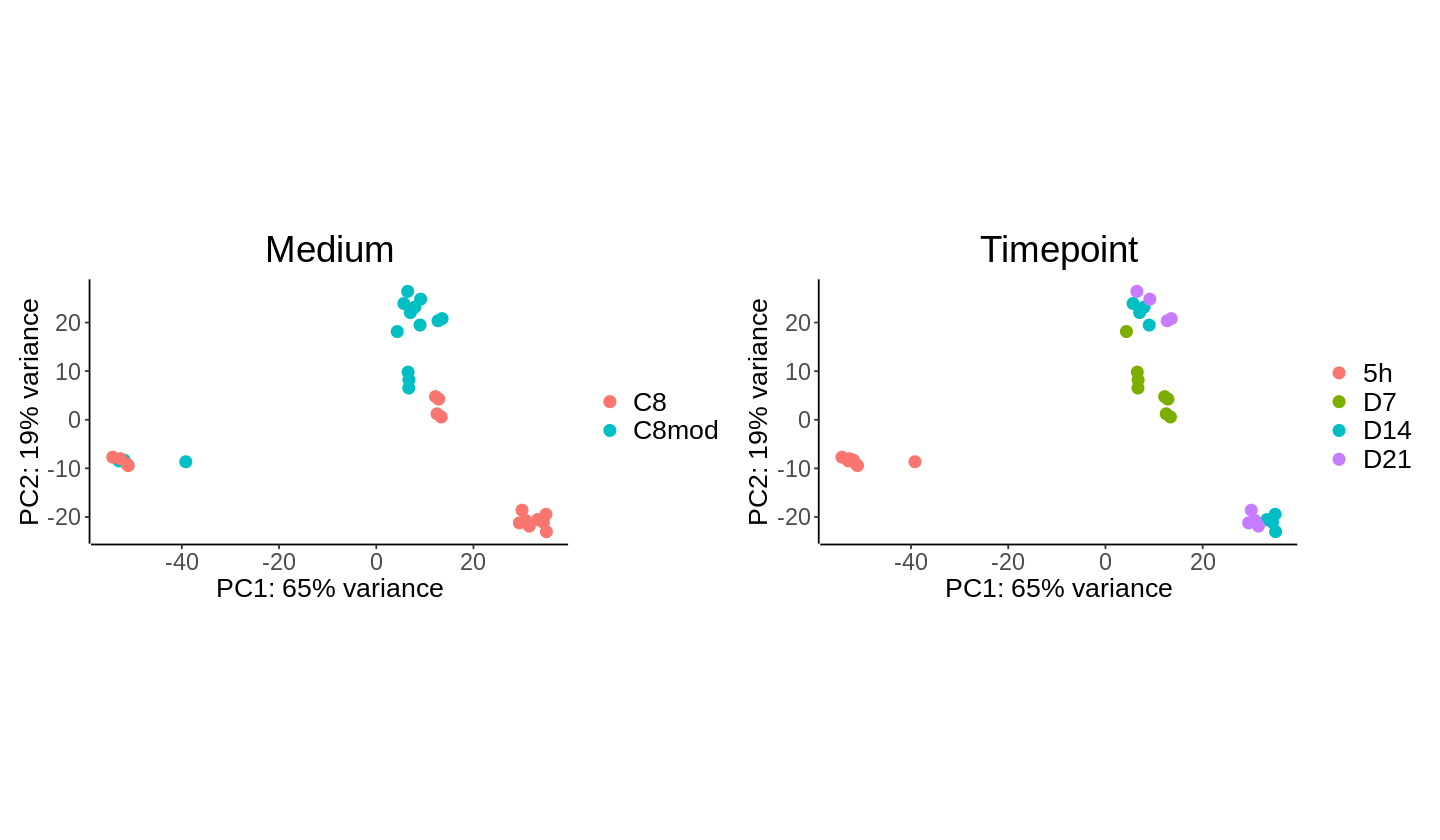

In [11]:
options(repr.plot.width = 12)

pca.1 <- plotPCA(rld, intgroup = c("Medium")) + ggtitle("Medium") +
              theme_bw() + 
              theme(panel.border = element_blank(), 
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(), 
                    axis.line = element_line(colour = "black")) +
              theme(plot.title = element_text(hjust = 0.5, size = 22)) +
              theme(legend.text = element_text(size = 16)) +
              theme(legend.title = element_blank()) +
              theme(axis.text.x = element_text(size = 14),
                    axis.text.y = element_text(size = 14),
                    axis.title.x = element_text(size = 16),
                    axis.title.y = element_text(size = 16)) 
              
pca.2 <- plotPCA(rld, intgroup = c("Timepoint")) + ggtitle("Timepoint")  +
              theme_bw() + 
              theme(panel.border = element_blank(), 
                    panel.grid.major = element_blank(),
                    panel.grid.minor = element_blank(), 
                    axis.line = element_line(colour = "black")) +
              theme(plot.title = element_text(hjust = 0.5, size = 22)) +
              theme(legend.text = element_text(size = 16)) +
              theme(legend.title = element_blank()) +
              theme(axis.text.x = element_text(size = 14),
                    axis.text.y = element_text(size = 14),
                    axis.title.x = element_text(size = 16),
                    axis.title.y = element_text(size = 16))

pca.1 + pca.2

## 1.2. Differential expression analysis
The following chunk performs the likelihood ratio test, where we remove the medium-specific differences over time. Genes with small p-values from this test are those which, at one or more time points after time 0 showed a medium-specific effect. Note therefore that this will not give small p-values to genes which moved up or down over time in the same way in both media.

In [12]:
dds <- DESeq(dds, test = "LRT", fitType = "local", reduced = ~ Medium + Timepoint)
res <- results(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [13]:
summary(res)


out of 32269 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3378, 10%
LFC < 0 (down)     : 3540, 11%
outliers [1]       : 0, 0%
low counts [2]     : 16788, 52%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [14]:
# save normalized matrix for GEO
write.table(counts(dds, normalized = TRUE), file = "data/normalized_counts.tsv", sep = "\t", quote = FALSE)

## 2. Calling the gene set scoring function

The genesetscoring function is designed to take a character vector of gene symbols and calculate the average expression levels of each program (gene ontology) per sample, subtracted by the aggregated expression of control feature sets.
All analyzed features are binned based on averaged expression, and the control features are randomly selected from each bin.

Input argument explanation:

- dds: a DESeqDataSet
- features: a character vector of gene names
- pool: list of features to check expression levels against, defaults to `rownames(x = counts(dds))`.
- nbin: number of bins of aggregate expression levels for all analyzed features
- ctrl: number of control features selected from the same bin per analyzed feature
- name: name for the expression program
- seed: set a random seed. If NULL, no seed is set.

In [15]:
source("modulescoring/geneset_modulescoring.R")

Let's test the module scoring for a random gene set, which contains a character not present in the gene lists.

In [16]:
features <- c("ALPL", "IHH", "COL2A1", "qwerty") # Random test features


dds <- AddGeneSetScore(dds, 
                       nbin = 12,
                       features = features,
                       ctrl = 5,
                       name = 'Test_Features'
                       )

Warning message in FUN(X[[i]], ...):
“The following features are not present in the object: qwerty”
Warning message in FUN(X[[i]], ...):
“
 qwerty dropped for calculating the geneset score.”


The incorrect "gene" was dropped and a new column appears in `colData` containing scores per sample ranging from 0 to 1. The column name is defined by the `name` argument.

In [17]:
colData(dds)

DataFrame with 32 rows and 7 columns
           Experiment        Pool Timepoint     Platform   Medium sizeFactor
          <character> <character>  <factor>  <character> <factor>  <numeric>
GC1001709  IVH_SRV_ID       TEVII        5h AggreWell800    C8mod   1.210302
GC1001710  IVH_SRV_ID       TEVII        5h AggreWell800    C8mod   0.204322
GC1001711  IVH_SRV_ID       TEVII        5h AggreWell800    C8mod   1.033601
GC1001712  IVH_SRV_ID       TEVII        5h AggreWell800    C8mod   1.286333
GC1003617  IVH_SRV_ID       TEVII        D7 AggreWell800    C8mod   1.819933
...               ...         ...       ...          ...      ...        ...
GC1003644      TH_GNH       TEVII       D14 AggreWell800       C8    0.79901
GC1003645      TH_GNH       TEVII       D21 AggreWell800       C8    1.28582
GC1003646      TH_GNH       TEVII       D21 AggreWell800       C8    1.39580
GC1003647      TH_GNH       TEVII       D21 AggreWell800       C8    1.37832
GC1003648      TH_GNH       TEVII      

In [18]:
min(dds$Test_Features1)
max(dds$Test_Features1)

[1] 0

[1] 1

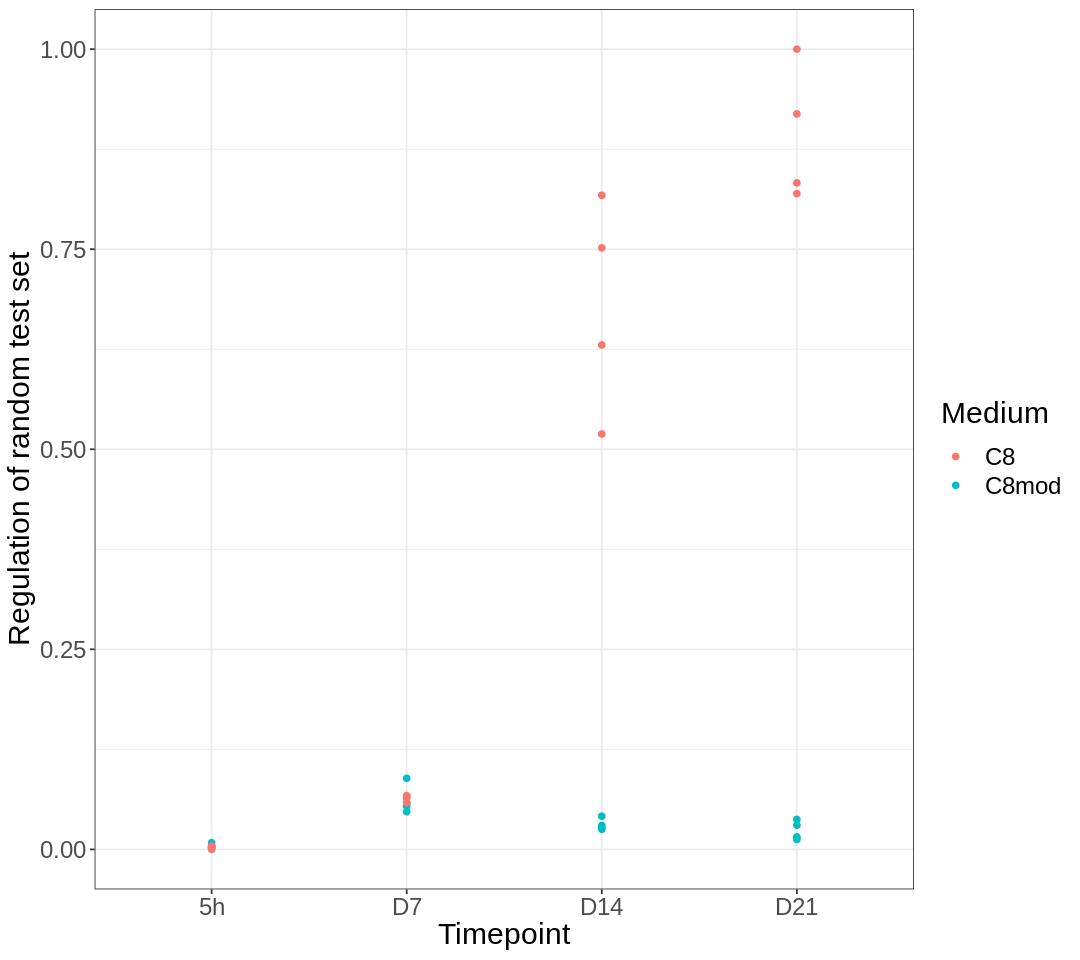

In [19]:
options(repr.plot.width = 9, repr.plot.height = 8)

ggplot(as.data.frame(colData(dds)), aes(x = Timepoint, y = Test_Features1, color = Medium)) + 
    geom_point() +
    theme_bw() + 
    ylab("Regulation of random test set") + 
    theme(text = element_text(size = 18))